In [ ]:
!nvidia-smi

Tue Nov 23 18:58:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=193SeaovPhz9wBnKiP2iyhLiPTnNGo2EG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=193SeaovPhz9wBnKiP2iyhLiPTnNGo2EG" -O PH2Dataset.rar && rm -rf /tmp/cookies.txt

--2021-11-23 18:58:54--  https://docs.google.com/uc?export=download&confirm=0ZDD&id=193SeaovPhz9wBnKiP2iyhLiPTnNGo2EG
Resolving docs.google.com (docs.google.com)... 173.194.74.138, 173.194.74.100, 173.194.74.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.74.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-30-docs.googleusercontent.com/docs/securesc/4mlpf2mkptais1ajoki4dn6nps3l06h0/7ae6tghh7peqrqls7emcdrh1abcf870a/1637693925000/14530628072408688014/10765424319195701328Z/193SeaovPhz9wBnKiP2iyhLiPTnNGo2EG?e=download [following]
--2021-11-23 18:58:54--  https://doc-14-30-docs.googleusercontent.com/docs/securesc/4mlpf2mkptais1ajoki4dn6nps3l06h0/7ae6tghh7peqrqls7emcdrh1abcf870a/1637693925000/14530628072408688014/10765424319195701328Z/193SeaovPhz9wBnKiP2iyhLiPTnNGo2EG?e=download
Resolving doc-14-30-docs.googleusercontent.com (doc-14-30-docs.googleusercontent.com)... 142.250.103.132, 2607:f8b0:4001:c2b::84
Connectin

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):#в root записаны названия папок, которые содержатся в images
    if root.endswith('_Dermoscopic_Image'):#если мы открыли папку с Dermoscopic, считываем картинку imread(выдает матрицу) и добавляем ее в images 
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]  # здесь записаны ответы 

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

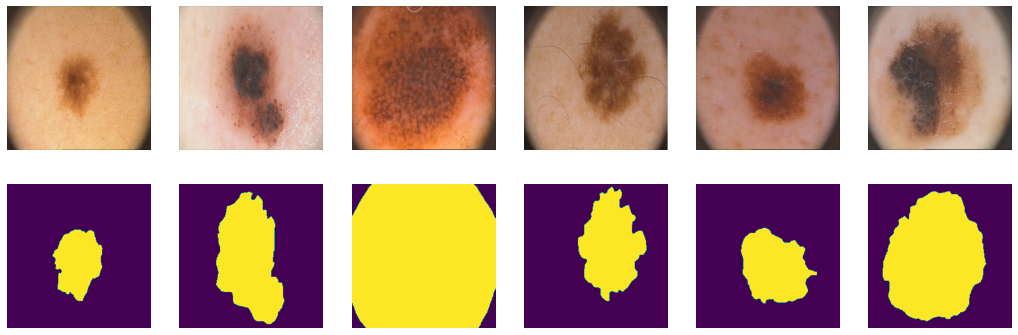

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [ ]:
ix = np.random.choice(len(X), len(X) ,False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
for i,j in data_ts:
  print(i.shape,j.shape)
print(j[1,0,1].max())

torch.Size([25, 3, 256, 256]) torch.Size([25, 1, 256, 256])
torch.Size([25, 3, 256, 256]) torch.Size([25, 1, 256, 256])
tensor(0.)


### SegNet


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0=nn.Sequential(
          nn.Conv2d(in_channels=3,out_channels=8,stride=1,kernel_size=3,dilation=2,padding=2), 
          nn.BatchNorm2d(8),
          nn.ReLU(inplace=True), 

          nn.Conv2d(in_channels=8,out_channels=16,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(16),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=16,out_channels=32,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)  # 256 -> 128

       
        self.enc_conv1 = nn.Sequential(
          nn.Conv2d(in_channels=32,out_channels=50,stride=1,kernel_size=3,dilation=2,padding=2), 
          nn.BatchNorm2d(50),
          nn.ReLU(inplace=True), 

          nn.Conv2d(in_channels=50,out_channels=80,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(80),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=80,out_channels=120,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(120),
          nn.ReLU(inplace=True)
        )
      
        self.pool1 =nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
          nn.Conv2d(in_channels=120,out_channels=140,stride=1,kernel_size=3,dilation=2,padding=2), 
          nn.BatchNorm2d(140),
          nn.ReLU(inplace=True), 

          nn.Conv2d(in_channels=140,out_channels=160,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(160),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=160,out_channels=180,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(180),
          nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True) # 64 -> 32

        self.enc_conv3 =nn.Sequential(
          nn.Conv2d(in_channels=180,out_channels=220,stride=1,kernel_size=3,dilation=2,padding=2), 
          nn.BatchNorm2d(220),
          nn.ReLU(inplace=True), 

          nn.Conv2d(in_channels=220,out_channels=260,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(260),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=260,out_channels=300,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(300),
          nn.ReLU(inplace=True)
        )
        self.pool3 =nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(300,300,1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2,stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
          nn.Conv2d(in_channels=300,out_channels=260,stride=1,kernel_size=3,dilation=2,padding=2), 
          nn.BatchNorm2d(260),
          nn.ReLU(inplace=True), 

          nn.Conv2d(in_channels=260,out_channels=220,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(220),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=220,out_channels=180,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(180),
          nn.ReLU(inplace=True)
        )






        self.upsample1 = nn.MaxUnpool2d(kernel_size=2,stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
          nn.Conv2d(in_channels=180,out_channels=160,stride=1,kernel_size=3,dilation=2,padding=2), 
          nn.BatchNorm2d(160),
          nn.ReLU(inplace=True), 

          nn.Conv2d(in_channels=160,out_channels=140,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(140),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=140,out_channels=120,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(120),
          nn.ReLU(inplace=True)
        )


        self.upsample2 = nn.MaxUnpool2d(kernel_size=2,stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
          nn.Conv2d(in_channels=120,out_channels=80,stride=1,kernel_size=3,dilation=2,padding=2), 
          nn.BatchNorm2d(80),
          nn.ReLU(inplace=True), 

          nn.Conv2d(in_channels=80,out_channels=50,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(50),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=50,out_channels=32,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True)
        )






        self.upsample3 =  nn.MaxUnpool2d(kernel_size=2,stride=2)  # 128 -> 256
        self.dec_conv3 =nn.Sequential(
          nn.Conv2d(in_channels=32,out_channels=16,stride=1,kernel_size=3,dilation=2,padding=2), 
          nn.BatchNorm2d(16),
          nn.ReLU(inplace=True), 

          nn.Conv2d(in_channels=16,out_channels=8,stride=1,kernel_size=3,dilation=2,padding=2),
          nn.BatchNorm2d(8),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=8,out_channels=1,stride=1,kernel_size=3,dilation=2,padding=2)
        )

    def forward(self, x):
        # encoder
        e0, index0 = self.pool0(self.enc_conv0(x))
        e1, index1 = self.pool1(self.enc_conv1(e0))
        e2, index2 = self.pool2(self.enc_conv2(e1))
        e3, index3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b,index3))
        d1 = self.dec_conv1(self.upsample1(d0,index2))
        d2 = self.dec_conv2(self.upsample2(d1,index1))
        d3 = self.dec_conv3(self.upsample3(d2,index0)) # no activation
        return d3

In [ ]:
b, y = next(iter(data_tr))
print(b[0].shape)
print(y[0].shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))         
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10 
    
    return thresholded  # 

In [ ]:
def bce_loss(y_real, y_pred):

  return torch.mean(y_pred-y_pred*y_real+torch.log(1+torch.exp(-y_pred)))


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val,scheduler1):
    X_val, Y_val = next(iter(data_val))
    history=[]
    acchistory=[]
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()
            Y_pred = model(X_batch) 
            loss = loss_fn(Y_batch,Y_pred) 
            loss.backward()  
            opt.step()  
      
            avg_loss += loss/ len(data_tr)

        scheduler1.step()

        acchistory.append(score_model(model, iou_pytorch, data_val).item())
        history.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)
      
        model.eval() 
        with torch.no_grad():
          inputs = X_val.to(device)
          Y_hat = model(inputs).cpu()

    
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
    return history, acchistory

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data:
          X_batch = X_batch.to(device)
          Y_real = Y_label.to(device)
          Y_pred = torch.clamp(torch.squeeze(model(X_batch)), min=0, max=1).round()
          scores += metric(Y_pred, Y_real).mean()

    return scores/len(data)

In [ ]:
sm=[]
historysm=[]
acchistorysm=[]

In [ ]:
model = SegNet().to(device)

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

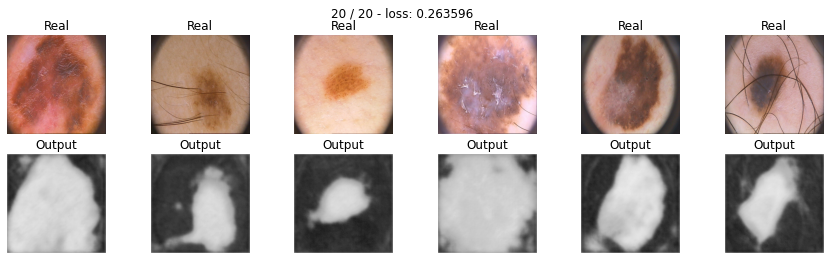

In [ ]:
max_epochs = 20
optim=torch.optim.Adam(model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(model, optim, bce_loss, max_epochs, data_tr, data_val,schedulur)
historysm.append(hsm)
acchistorysm.append(ahsm)

In [ ]:
sm.append(score_model(model, iou_pytorch, data_val).item())
sm[0]

0.3140000104904175

In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.clamp(y_pred,min=0,max=1)
    num = y_pred.shape[2]*y_pred.shape[3]
    eps = 1e-6
    den = 2*torch.sum(y_pred*y_real)/(torch.sum(y_pred+y_real)+eps)
    res = 1 - den/num
    return res 

Проводим тестирование:

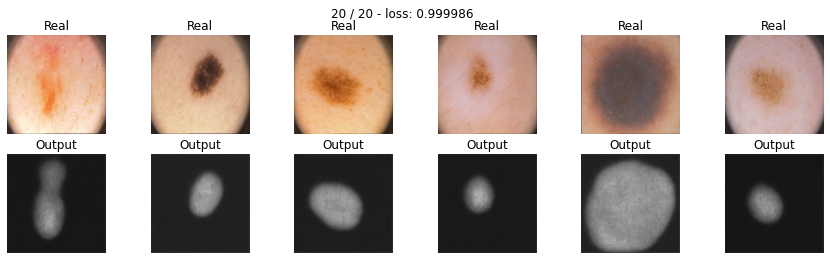

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_dice.parameters(),lr=1e-4)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val,schedulur)
historysm.append(hsm)
acchistorysm.append(ahsm)

In [ ]:
sm.append(score_model(model_dice, iou_pytorch, data_val).item())
sm[1]

0.6419999599456787

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred,min=0,max=1)# hint: torch.clamp
    your_loss=-torch.mean((1-torch.sigmoid(y_pred))**gamma*y_real*torch.log(torch.sigmoid(y_pred))+(1-y_real)*torch.log(1-torch.sigmoid(y_pred)))
    return your_loss


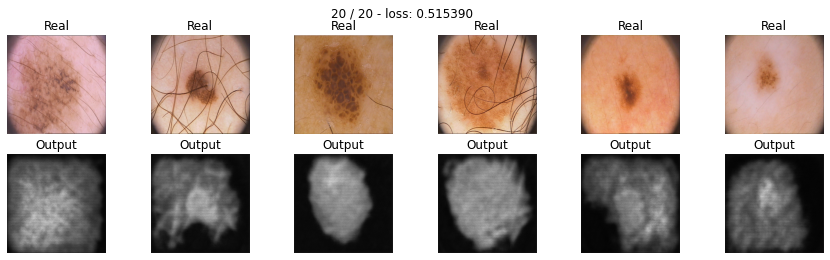

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_focal.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val,schedulur)
historysm.append(hsm)
acchistorysm.append(ahsm)

In [ ]:
sm.append(score_model(model_focal, iou_pytorch, data_val).item())
sm[2]

0.3880000114440918

In [ ]:
from torch.autograd import Variable
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: 
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(labels, logits, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    
    loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

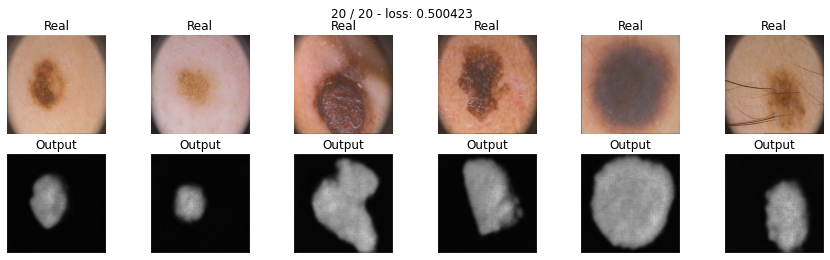

In [ ]:
model_lovasz = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_lovasz.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(model_lovasz, optimaizer, lovasz_hinge, max_epochs, data_tr, data_val,schedulur)
historysm.append(hsm)
acchistorysm.append(ahsm)

In [ ]:
sm.append(score_model(model_focal, iou_pytorch, data_val).item())
sm[3]

0.3880000114440918

### U-Net


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)  # 256 -> 128


        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)# 128 -> 64



        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True) # 64 -> 32


        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        ) 
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2,return_indices=True)# 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256,256,1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2,stride=2) # 16 -> 32
        
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=256,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        ) 



        self.upsample1 = nn.MaxUnpool2d(kernel_size=2,stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) 


        self.upsample2 = nn.MaxUnpool2d(kernel_size=2,stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) 



        self.upsample3 = nn.MaxUnpool2d(kernel_size=2,stride=2)   # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),


            nn.Conv2d(in_channels=16,out_channels=1,kernel_size=3,dilation=2,padding=2)
        ) 

    def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e01, index0 = self.pool0(e00)#256-128

        e10 = self.enc_conv1(e01)  
        e11, index1 = self.pool1(e10)#128-64

        e20 = self.enc_conv2(e11) 
        e21, index2 = self.pool2(e20) #64-32

        e30 = self.enc_conv3(e21) 
        e31, index3 = self.pool3(e30) #32-16
        # bottleneck
        b = self.bottleneck_conv(e31)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b,index3),e30),dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0,index2),e20),dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1,index1),e10),dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2,index0),e00),dim=1))
        return d3

In [ ]:
su=[]
historysu=[]
acchistorysu=[]

In [ ]:
unet_model = UNet().to(device)

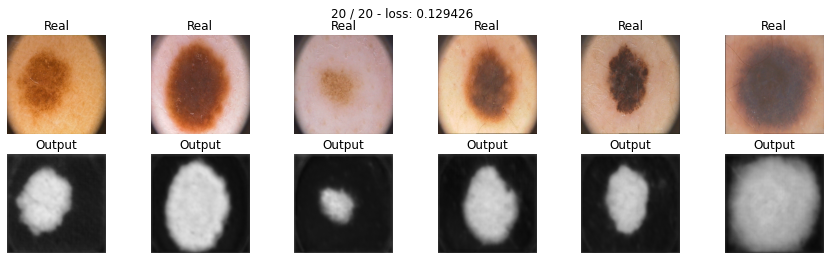

In [ ]:
max_epochs = 20
optim=torch.optim.Adam(unet_model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(unet_model, optim, bce_loss, max_epochs, data_tr, data_val,schedulur)
historysu.append(hsm)
acchistorysu.append(ahsm)

In [ ]:
su.append(score_model(unet_model, iou_pytorch, data_val).item())
su[0]

0.7139999866485596

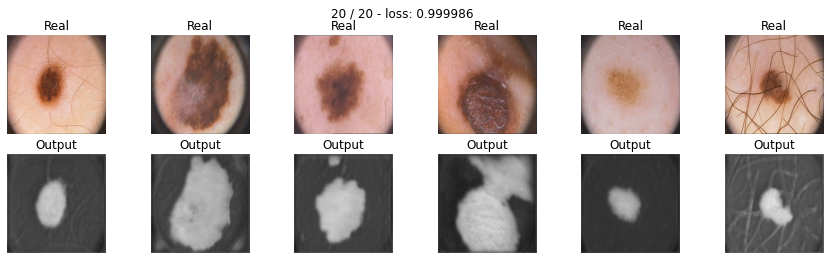

In [ ]:
unet_model = UNet().to(device)
max_epochs = 20
optim=torch.optim.Adam(unet_model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(unet_model, optim, dice_loss, max_epochs, data_tr, data_val,schedulur)
historysu.append(hsm)
acchistorysu.append(ahsm)

In [ ]:
su.append(score_model(unet_model, iou_pytorch, data_val).item())
su[1]

0.7200000286102295

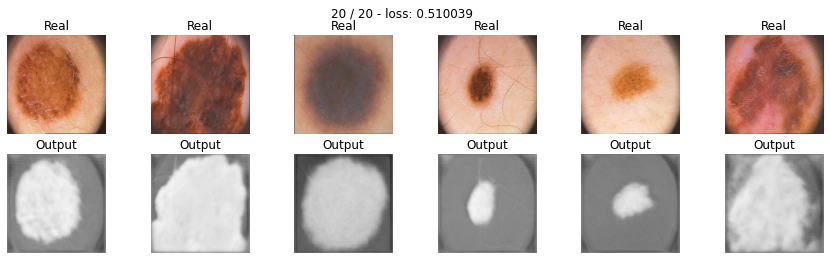

In [ ]:
unet_model = UNet().to(device)
max_epochs = 20
optim=torch.optim.Adam(unet_model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(unet_model, optim, focal_loss, max_epochs, data_tr, data_val,schedulur)
historysu.append(hsm)
acchistorysu.append(ahsm)

In [ ]:
su.append(score_model(unet_model, iou_pytorch, data_val).item())
su[2]

0.5659999847412109

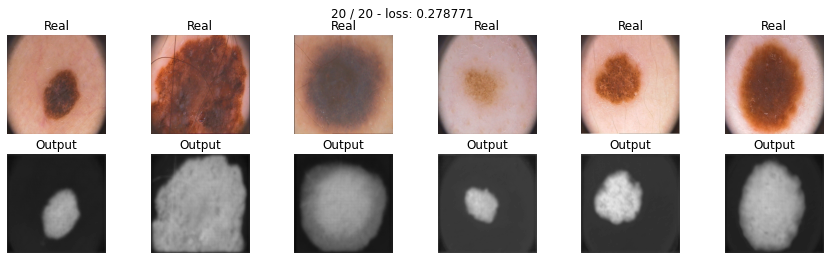

In [ ]:
unet_model = UNet().to(device)
max_epochs = 20
optim=torch.optim.Adam(unet_model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(unet_model, optim, lovasz_hinge, max_epochs, data_tr, data_val,schedulur)
historysu.append(hsm)
acchistorysu.append(ahsm)

In [ ]:
su.append(score_model(unet_model, iou_pytorch, data_val).item())
su[3]

0.6679999828338623

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.pool0 = nn.Sequential(
                nn.Conv2d(32, 32, 3, padding=1),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1) 
                 )  


        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),           
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.pool1 = nn.Sequential(
                nn.Conv2d(128, 128, 3, padding=1),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1) 
                 )  


        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool2 = nn.Sequential(
                nn.Conv2d(256, 256, 3, padding=1),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1) 
                 )  

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),

        ) 
        self.pool3 = nn.Sequential(
                nn.Conv2d(512, 512, 3, padding=1),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1) 
                 )  

        self.bottleneck_conv = nn.Conv2d(512,400,1)

        self.upsample0 = nn.Sequential(
            nn.Upsample(32),
            nn.Conv2d(400,400,3,padding=1)
        ) # 16 -> 32
        
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=912,out_channels=512,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512,out_channels=300,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(300)
        ) 



        self.upsample1 =nn.Sequential(
            nn.Upsample(64),
            nn.Conv2d(300,300,3,padding=1)
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=556,out_channels=300,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(300),
            nn.Conv2d(in_channels=300,out_channels=200,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(200)
        ) 


        self.upsample2 = nn.Sequential(
            nn.Upsample(128),
            nn.Conv2d(200,200,3,padding=1)
        ) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=328,out_channels=200,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(200),
            nn.Conv2d(in_channels=200,out_channels=100,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        ) 



        self.upsample3 = nn.Sequential(
            nn.Upsample(256),
            nn.Conv2d(100,100,3,padding=1)
        )   # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=132,out_channels=64,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,dilation=2,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),


            nn.Conv2d(in_channels=32,out_channels=1,kernel_size=3,dilation=2,padding=2)
        ) 

    def forward(self, x):
        e00 = self.enc_conv0(x)
        e01 = self.pool0(e00)#256-128

        e10 = self.enc_conv1(e01)  
        e11= self.pool1(e10)#128-64

        e20 = self.enc_conv2(e11) 
        e21 = self.pool2(e20) #64-32

        e30 = self.enc_conv3(e21) 
        e31 = self.pool3(e30) #32-16
        # bottleneck
        b = self.bottleneck_conv(e31)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b),e30),dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0),e20),dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1),e10),dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2),e00),dim=1))  # no activation
        return d3


In [ ]:
su2=[]
historysu2=[]
acchistorysu2=[]

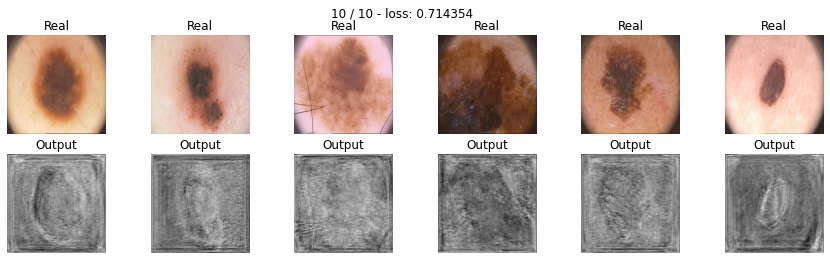

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 10
optim=torch.optim.Adam(unet_model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(unet2_model, optim, bce_loss, max_epochs, data_tr, data_val,schedulur)
historysu2.append(hsm)
acchistorysu2.append(ahsm)


In [ ]:
su2.append(score_model(unet2_model, iou_pytorch, data_val).item())
su2[0]

0.0

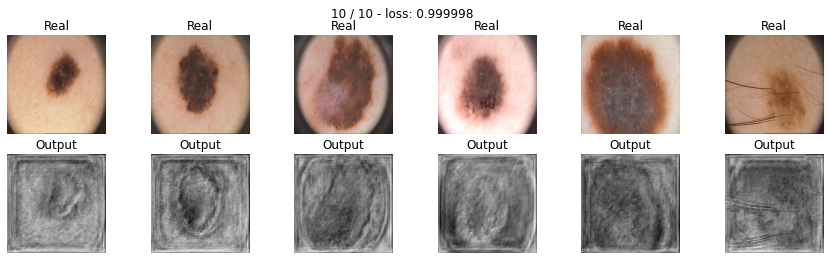

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 10
optim=torch.optim.Adam(unet_model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(unet2_model, optim, dice_loss , max_epochs, data_tr, data_val,schedulur)
historysu2.append(hsm)
acchistorysu2.append(ahsm)

In [ ]:
su2.append(score_model(unet2_model, iou_pytorch, data_val).item())
su2[1]

0.0

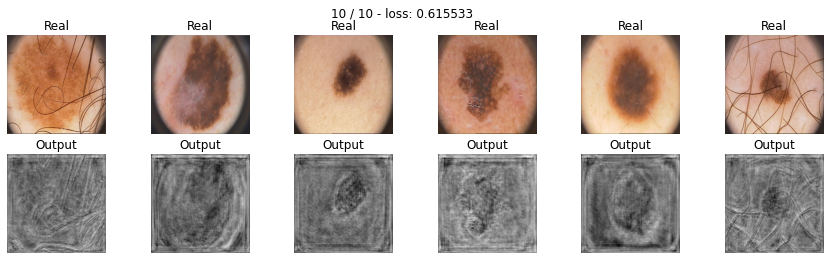

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 10
optim=torch.optim.Adam(unet_model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(unet2_model, optim, focal_loss, max_epochs, data_tr, data_val,schedulur)
historysu2.append(hsm)
acchistorysu2.append(ahsm)


In [ ]:
su2.append(score_model(unet2_model, iou_pytorch, data_val).item())
su2[2]

0.0

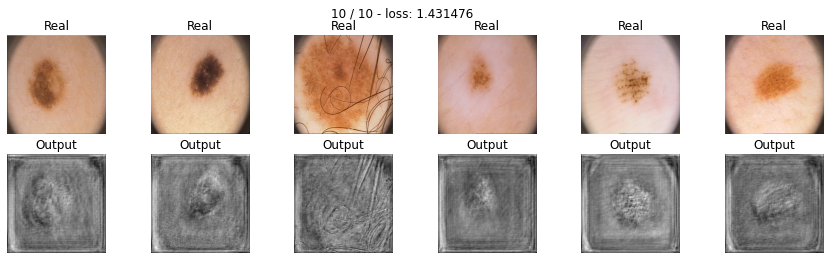

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 10
optim=torch.optim.Adam(unet_model.parameters(),lr=1e-3)
schedulur=MultiStepLR(optim,[10],gamma=0.1)
hsm,ahsm=train(unet2_model, optim, lovasz_hinge, max_epochs, data_tr, data_val,schedulur)
historysu2.append(hsm)
acchistorysu2.append(ahsm)


In [ ]:
su2.append(score_model(unet2_model, iou_pytorch, data_val).item())
su2[3]

0.0

###Основные итоги работы


In [ ]:
acc=[acchistorysm,acchistorysu,acchistorysu2]
hs=[historysm,historysu,historysu2]
names=['SegNet','U-net','U-net2']

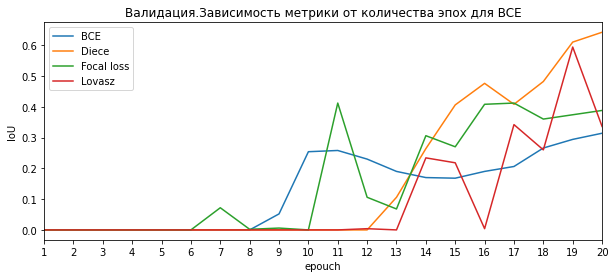

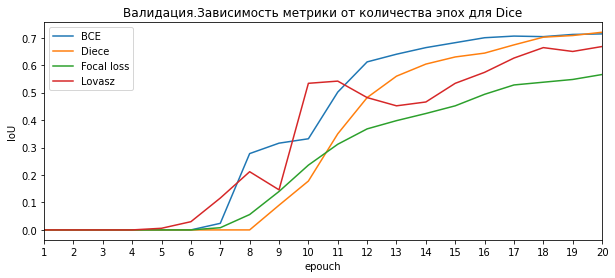

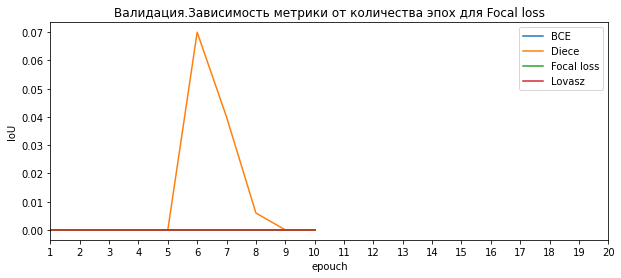

In [ ]:
n=0
for i in acc:
  plt.figure(figsize=(10,4))
  for y in i:
      x=np.arange(1,len(y)+1)
      plt.plot(x,y)
      plt.xlim(x[0],x[-1])
      plt.xticks(np.arange(1,21,1))
  plt.title('Валидация.Зависимость метрики от количества эпох для {}'.format(names[n]))     
  plt.legend(('BCE','Diece','Focal loss','Lovasz')) 
  plt.ylabel('IoU')
  plt.xlabel('epouch')
  plt.show()
  n+=1



В случае SegNet, исходя из графика, наилучшим выбором будет выбор Diece. Функции IoU(epouch) в случае Diece, Focal и BCE не вышли на видимое "насыщение"(Подразумивается, что сильно падает d(IoU)/d(epouch), не уверен, что у таких графиков есть точная асимптота), следовательно модель можно обучать на большем количестве эпох. Lovasz и BCE имееют одинаковую в пределах погрешности точность, которая отличается от максимальной (Diece) на 30$\pm$5 %.


В случае U-net наибольшее значение метрики IoU достигается при выборе BCE,Lovasz loss и Diece, причем только при BCE график вышел на "насыщение", следовательно модель можно было обучать дольше. Focal loss так же относительно неплохой выбор разница в метрике 20$\pm 4$% относительно BCE


Модель U-net2 показывает наиболее плохую сходимость относительно предыдущих конфигураций сетей для любых лосс функций. Вероятно, модель переобучается.






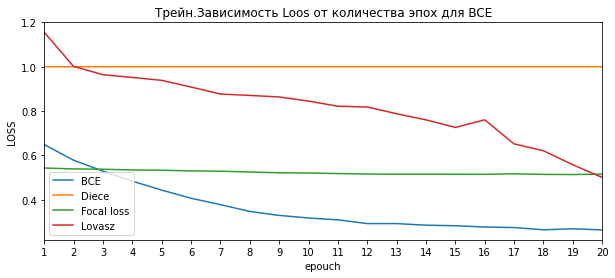

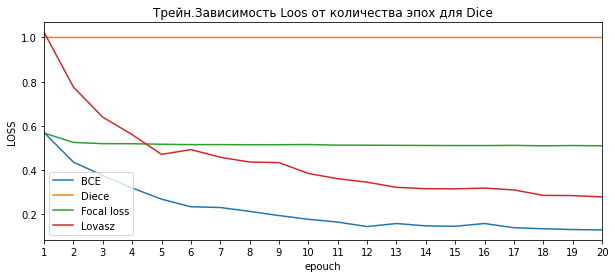

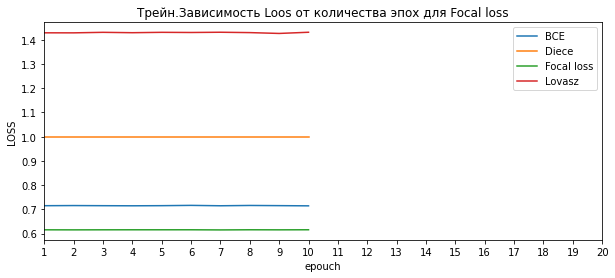

In [ ]:
n=0
for i in hs:
  plt.figure(figsize=(10,4))
  for y in i:
      x=np.arange(1,len(y)+1)
      plt.plot(x,y)
      plt.xlim(x[0],x[-1])
      plt.xticks(np.arange(1,21,1))
  plt.title('Трейн.Зависимость Loos от количества эпох для {}'.format(names[n]))     
  plt.legend(('BCE','Diece','Focal loss','Lovasz')) 
  plt.ylabel('LOSS')
  plt.xlabel('epouch')
  plt.show()
  n+=1

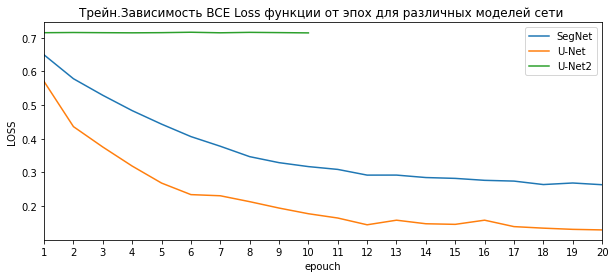

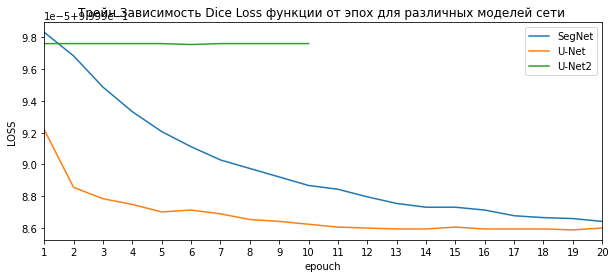

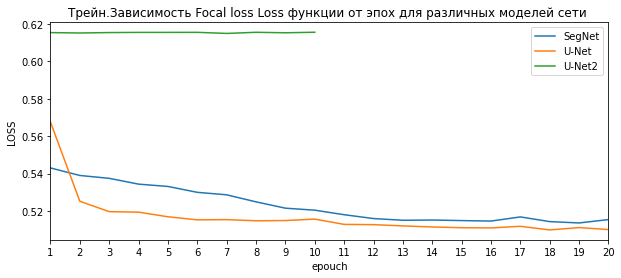

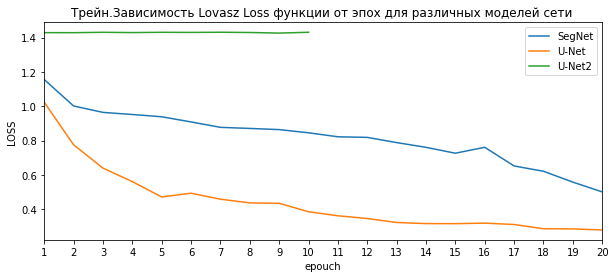

In [ ]:
n=0
names=['BCE','Dice','Focal loss','Lovasz']
for i in range(4):
  plt.figure(figsize=(10,4))
  for y in range(3):
      x=np.arange(1,len(hs[y][i])+1)
      plt.plot(x,hs[y][i])
      plt.xlim(x[0],x[-1])
      plt.xticks(np.arange(1,21,1))
  plt.title('Трейн.Зависимость {} Loss функции от эпох для различных моделей сети '.format(names[n]))     
  plt.legend(('SegNet','U-Net','U-Net2')) 
  plt.ylabel('LOSS')
  plt.xlabel('epouch')
  plt.show()
  n+=1

Исходя из графиков, архетектура U-net2 не обучаестя, Losses функции выглядят как прямые горизотальные линии, что не характерно для графиков Loss для других архетектур. Игнорируя U-net2 и Lovasz loss(epouch) для Segnet можно сказать, что d(Loss function)/d(epouch) приближаются справа к нулю и Loss постепенно выходит на насыщение. (Есть минимальная точка лосса, но нет гарантии, что он к ней сойдется, может быть и локальная точка минимума, Adam с подсчетом градиента не умееют выходить из минимальных точек настолько эффективно, как известные мне случайне методы Эволюции и Отжига)